# CLASSIFICATION OF CONTACTS IN PROTEIN STRUCTURE
### A project by Antonio Feltrin, Emma Lovato and Mattia Piazza

## Introduction
Residue Interaction Networks (RINs) are derived from protein structures based on geometrical and physico-chemical properties of amino acids. 

RING is a software tool that takes a PDB file as input and returns the list of contacts (residue-residue pairs) and their types in a protein structure.

The contact types include: 
- Hydrogen bonds (HBOND)
- Van der Waals interactions (VDW)
- Disulfide bridges (SSBOND)
- Salt bridges (IONIC)
- π-π stacking (PIPISTACK)
- π-cation (PICATION)
- π-hydrogen bond (PIHBOND)

## Goal
The goal of this project is to develop a software tool that predicts the RING classification of a contact based on statistical or supervised learning methods, rather than geometrical constraints. This report details the implementation and results of our approach.

## Methods
We implemented a learning approach to classify contacts in protein structures. The implementation includes features extraction, diverse models training, and evaluation.

## Importing Libraries


In [1]:
pip install torch hiddenlayer imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import hiddenlayer as hl
import random
import joblib
import torch
import logging
import os

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import (
    GaussianNB,
    MultinomialNB,
    CategoricalNB,
    ComplementNB,
    BernoulliNB,
)
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold, HalvingRandomSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, matthews_corrcoef, balanced_accuracy_score
from itertools import cycle
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score



## Pre-Processing
Extract features from PDB files, handling missing values, scaling features, and encoding categorical variables.

In [3]:
random.seed(42)

In [4]:
path_to_data = Path("../data")

df_complete = pd.read_csv(path_to_data / "df_complete.csv")
df_complete.head()

,Unnamed: 0,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,0,1u9c,A,32,,Y,H,0.149,22.0,24.0,...,11.0,-1.163,-0.725,H,-1.006,-0.590,1.891,-0.397,0.412,NaN
1,1,1u9c,A,112,,L,H,0.000,25.0,25.0,...,16.0,-1.136,-0.853,H,-0.591,-1.302,-0.733,1.570,-0.146,HBOND
2,2,1u9c,A,107,,T,H,0.162,11.0,16.0,...,21.0,-1.128,-0.789,H,0.260,0.830,3.097,-0.838,1.512,NaN
3,3,1u9c,A,147,,K,-,0.190,18.0,8.0,...,17.0,-1.631,1.771,H,0.945,0.828,1.299,-0.169,0.933,HBOND
4,4,1u9c,A,109,,Q,H,0.263,13.0,21.0,...,25.0,-1.135,-0.671,H,-1.019,-0.987,-1.505,1.266,-0.912,NaN


In [5]:
# Remove all rows with NaN in at least one column
# including rows with missing class (they could be false negatives)
df_complete.dropna(inplace=True)

# Define ground truth values
y = df_complete["Interaction"].astype("category")
y.head()

1    HBOND
3    HBOND
6    HBOND
7      VDW
9    HBOND
Name: Interaction, dtype: category
Categories (7, object): ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']

In [6]:
# Starting with a smaller dataset
new_df = pd.DataFrame(df_complete.iloc[:1000000, :])
new_df.dropna(inplace=True)

# Esplora il dataset per vedere quali colonne sono disponibili
print(new_df.columns)

y = new_df["Interaction"].astype("category")

# Define training features
X = new_df[
    [
        "s_ss8",
        "s_ss3",
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_ss8",
        "t_ss3",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
    ]
]

# Calculate percentiles and transform into categories
X = X.rank(pct=True).round(1).astype("category")

# Split the dataset to define training and testing examples
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

Index(['Unnamed: 0', 'pdb_id', 's_ch', 's_resi', 's_ins', 's_resn', 's_ss8',
       's_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_ss3', 's_a1', 's_a2',
       's_a3', 's_a4', 's_a5', 't_ch', 't_resi', 't_ins', 't_resn', 't_ss8',
       't_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_ss3', 't_a1', 't_a2',
       't_a3', 't_a4', 't_a5', 'Interaction'],
      dtype='object')


In [ ]:
bonds = ["HBOND", "IONIC", "PICATION", "PIHBOND", "PIPISTACK", "SSBOND", "VDW"]

for bond in bonds:
    print(f"this is new_df {bond}: {len(new_df[new_df["Interaction"] == bond])}")
    print(f"this is df {bond}: {len(df_complete[df_complete["Interaction"] == bond])}\n")

this is new_df HBOND: 557203
this is df HBOND: 820333

this is new_df IONIC: 18494
this is df IONIC: 27538

this is new_df PICATION: 4583
this is df PICATION: 6874

this is new_df PIHBOND: 1127
this is df PIHBOND: 1669

this is new_df PIPISTACK: 20447
this is df PIPISTACK: 30117

this is new_df SSBOND: 1126
this is df SSBOND: 1657

this is new_df VDW: 397020
this is df VDW: 583192



## Test different versions of Naive Bayes

In [ ]:
nb = GaussianNB()
y_new_pred = nb.fit(X_new_train, y_new_train).predict(X_new_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
)

Number of mislabeled points out of a total 100000 points : 52272


In [ ]:
nb = MultinomialNB()
y_new_pred = nb.fit(X_new_train, y_new_train).predict(X_new_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
)

Number of mislabeled points out of a total 100000 points : 44195


In [ ]:
nb = ComplementNB()
y_new_pred = nb.fit(X_new_train, y_new_train).predict(X_new_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
)

Number of mislabeled points out of a total 100000 points : 60102


In [ ]:
nb = BernoulliNB()
y_new_pred = nb.fit(X_new_train, y_new_train).predict(X_new_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
)

Number of mislabeled points out of a total 100000 points : 44042


In [ ]:
nb = CategoricalNB()
y_new_pred = nb.fit(X_new_train, y_new_train).predict(X_new_test)
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
)

Number of mislabeled points out of a total 100000 points : 43581


## Random Forest
The Random Forest classifier was chosen for its robustness and ability to handle large datasets with high dimensionality.

For classification tasks, it outputs the class that is the mode of the classes output by individual trees. The underlying principle involves two main steps:

- Bootstrap Aggregating (Bagging): Random subsets of the training data are used to train each tree. This helps in reducing the variance of the model without increasing the bias.
- Random Feature Selection: At each split in the tree, a random subset of features is considered, ensuring that the trees are de-correlated.

### Model implementation
We implemented the Random Forest algorithm, a powerful ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes for classification tasks.

We create the model and then the performance of the model is evaluated by calculating the number of mislabeled points and the overall accuracy.


In [ ]:
#Train the RF model 
y_new_pred = RandomForestClassifier().fit(X_new_train, y_new_train).predict(X_new_test)

# Performance of the model
print(
    "Number of mislabeled points out of a total %d points : %d"
    % (X_new_test.shape[0], (y_new_test != y_new_pred).sum())
 )

accuracy = accuracy_score(y_new_test, y_new_pred)
print("Accuracy:", accuracy)

KeyboardInterrupt: 

### Results
The trained Random Forest model is evaluated on the test set. 

The performance metrics indicate the effectiveness of the model. The number of mislabeled points out of the total test points is printed, followed by the accuracy of the model. The accuracy achieved demonstrates the model's capability in classifying the contact types in the protein structures.

## Logistic Regression

### Model training
We trained a Logistic Regression model for multi-class classification. The target variable is the interaction type, and the features are the various structural and physico-chemical properties of the residues involved in the contact.

In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Standardize
    ('logreg', LogisticRegression(random_state=42))
])

# Define the hyperparameter grid
param_dist = {
    'logreg__C': uniform(loc=0.1, scale=5),  # Reduce the range of C values
    'logreg__solver': ['liblinear'],
    'logreg__penalty': ['l2'],  # Only one penalty
    'logreg__max_iter': [100]  # Only one value for max_iter
}

# Define the cross-validation strategy:
# Use cross-validation to select the best model hyperparameters.
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Use fewer folds

# Perform hyperparameter search with HalvingRandomSearchCV
random_search = HalvingRandomSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_candidates=30,  # Limit the number of candidates
    factor=3,
    resource='n_samples',
    max_resources='auto',
    min_resources=50,  # Increase min_resources to start with more samples
    cv=cv_strategy, 
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# Fit the model:
# Training the Logistic Regression model on the training dataset.
random_search.fit(X_new_train, y_new_train)

# Best model
best_logreg = random_search.best_estimator_

# Results
print(f"Best score: {random_search.best_score_}")
print(f"Best parameters: {random_search.best_params_}")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 9
min_resources_: 50
max_resources_: 900000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 50
Fitting 3 folds for each of 30 candidates, totalling 90 fits
----------
iter: 1
n_candidates: 10
n_resources: 150
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 4
n_resources: 450
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 3
n_candidates: 2
n_resources: 1350
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.5466666666666666
Best parameters: {'logreg__C': 1.5607232426760909, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}


### Evaluation
The model is evaluated using the following metrics to assess the model performance:

- Cross-validation Accuracy: The average accuracy obtained across different splits of the data during cross-validation
- Accuracy: The ratio of correctly predicted instances to the total instances.
- Matthews Correlation Coefficient (MCC): A correlation coefficient between the observed and predicted binary classifications, considering true and false positives and negatives.
- Balanced Accuracy: he average of recall obtained on each class
- ROC-AUC: A metric that measures the area under the ROC curve, which plots the true positive rate against the false positive rate for different threshold values.
- Classification Report: 
    1. Precision: The ratio of true positive predictions to the total predicted positives for each class. It indicates how many of the predicted positive instances are actually correct.
    2. Recall: The ratio of true positive predictions to the total actual positives for each class. It measures how many of the actual positive instances are correctly predicted.
    3. F1-Score: The harmonic mean of precision and recall, providing a balance between the two metrics.
    4. Support: The number of actual occurrences of each class in the test set

In [ ]:
# Cross-validation 
cv = StratifiedKFold(n_splits=3) 
cv_scores = cross_val_score(best_logreg, X_new_train, y_new_train, cv=cv, scoring='accuracy', n_jobs=-1)  # Parallelization

print(f'Cross-validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}')

# Prediction
y_new_pred = best_logreg.predict(X_new_test)

# Evaluation metrichs 
accuracy = accuracy_score(y_new_test, y_new_pred)
mcc = matthews_corrcoef(y_new_test, y_new_pred)
balanced_acc = balanced_accuracy_score(y_new_test, y_new_pred)
roc_auc = roc_auc_score(pd.get_dummies(y_new_test), pd.get_dummies(y_new_pred), multi_class='ovo')

print(f'Accuracy: {accuracy:.2f}')
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')

print('Classification Report:')
print(classification_report(y_new_test, y_new_pred))

Cross-validation Accuracy: 0.57 ± 0.00
Accuracy: 0.57
Matthews Correlation Coefficient: 0.10
Balanced Accuracy: 0.28
ROC-AUC: 0.54
Classification Report:


c:\Users\emmal\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emmal\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       HBOND       0.58      0.96      0.72     55805
       IONIC       0.00      0.00      0.00      1923
    PICATION       0.00      0.00      0.00       461
     PIHBOND       0.00      0.00      0.00       116
   PIPISTACK       0.43      0.28      0.34      2069
      SSBOND       0.48      0.66      0.56        94
         VDW       0.46      0.07      0.12     39532

    accuracy                           0.57    100000
   macro avg       0.28      0.28      0.25    100000
weighted avg       0.51      0.57      0.45    100000



c:\Users\emmal\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We used then the CONFUSION MATRIX, that is a table used to evaluate the performance of a classification model. It provides a comprehensive insight into how well the model is making predictions by showing the actual versus predicted classifications.

The confusion matrix consists of four components:
- True Positives (TP): The number of instances correctly predicted as positive.
- True Negatives (TN): The number of instances correctly predicted as negative.
- False Positives (FP): The number of instances incorrectly predicted as positive (Type I error).
- False Negatives (FN): The number of instances incorrectly predicted as negative (Type II error).

For multiclass classification, the confusion matrix is an n×n matrix where n is the number of classes. Each cell (i,j) in the matrix represents the number of observations that are actually in class i but predicted to be in class j.


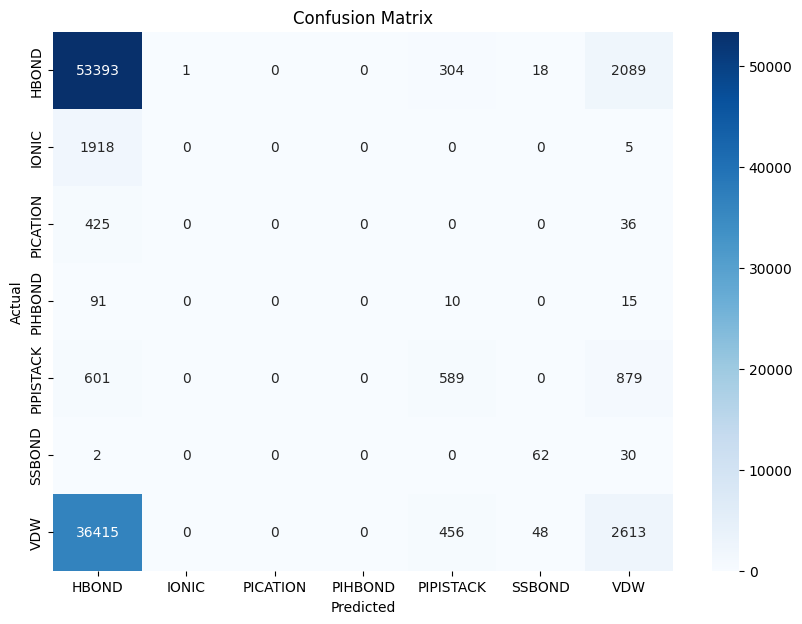

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_new_test, y_new_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The Receiver Operating Characteristic (ROC) curve is a graphical representation used to evaluate the performance of a classification model.
It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. 

The area under the ROC curve (AUC) provides a single measure of a classifier's performance across all classification thresholds.

Micro-average ROC: Aggregates the contributions of all classes to calculate a single ROC curve. It weights the results based on the frequency of the classes and is influenced by the most frequent class.

Macro-average ROC: Calculates a separate ROC curve for each class and then averages them. It treats each class with equal importance, regardless of their frequency, and weights each class equally.

When to use which?
- Micro-average ROC: when you want an overall measure of your model's performance that takes class distribution into account. It is suitable for datasets with imbalanced classes.
- Macro-average ROC: when you want to evaluate the average performance of your model across all classes without the class distribution affecting the result. It is suitable for datasets with balanced classes or when each class is equally important.

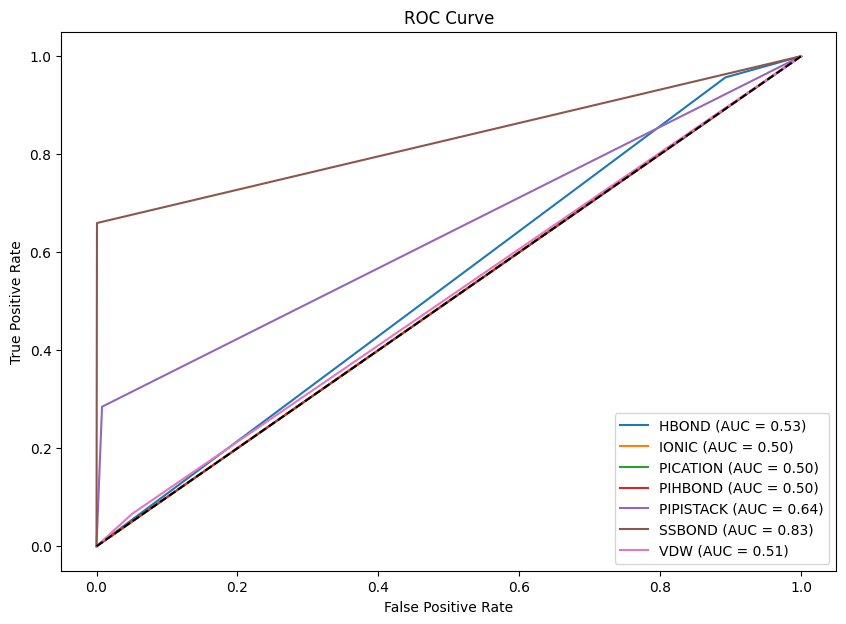

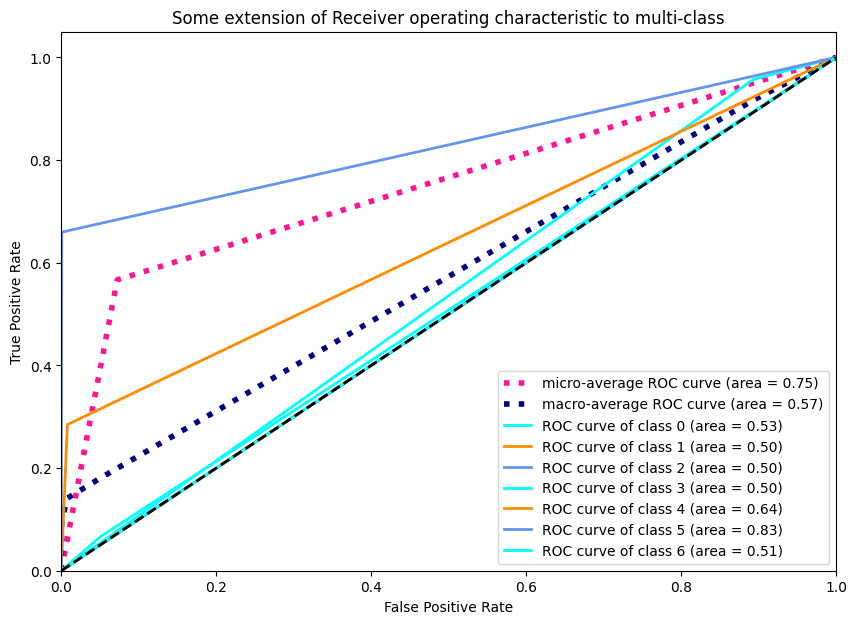

In [ ]:
# ROC Curve

# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_new_test, classes=np.unique(y))
y_pred_binarized = label_binarize(y_new_pred, classes=np.unique(y))

plt.figure(figsize=(10, 7))
for i, label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Results
- Cross-validation accuracy: It provides an estimate of how the model is expected to perform on unseen data. A value of 0.57 ± 0.00 indicates that the model has a consistent accuracy of 57% across the three folds.
- Accuracy: Accuracy measures how often the model correctly predicts the classes. An accuracy of 0.57 means the model correctly predicts 57% of the instances in the test set.
- MCC: MCC ranges from -1 to 1, where 1 indicates perfect prediction, 0 no better than random prediction, and -1 indicates total disagreement. An MCC of 0.10 suggests a low positive correlation between the predictions and the actual classes.
- Balanced Accuracy: This metric adjusts for imbalanced class distribution by considering the recall of each class. A balanced accuracy of 0.27 indicates poor performance, especially for less frequent classes.
- ROC-AUC: For multiclass classification, it is computed using the one-vs-one (ovo) method. A value of 0.54 indicates that the model's ability to distinguish between classes is only slightly better than random guessing.
- Classification report summary:
    1. HBOND: The model performs reasonably well with a precision of 0.57 and a recall of 0.96.
    2. IONIC, PICATION, PIHBOND: The model struggles with these classes, achieving very low precision and recall, indicating poor prediction capabilities.
    3. PIPISTACK: Shows moderate performance with a precision of 0.41 and a recall of 0.27.
    4. SSBOND: Has a relatively better performance with a precision of 0.54 and a recall of 0.61.
    5. VDW: The model performs poorly with a precision of 0.47 and a recall of 0.07.
    6. Overall Accuracy: The model's overall accuracy is 0.57, indicating that it correctly predicts 57% of the instances.
    7. Macro Average: Averages precision, recall, and F1-score across all classes, treating all classes equally. The macro averages are 0.34 (precision), 0.27 (recall), and 0.25 (F1-score).
    8. Weighted Average: Averages precision, recall, and F1-score across all classes, weighted by the number of instances of each class. The weighted averages are 0.52 (precision), 0.57 (recall), and 0.45 (F1-score).
- Confusion matrix describes that there are:
    1. Class Imbalance: The model shows varying performance across different classes, with the majority classes such as HBOND and VDW having higher accuracy. 
    This suggests that the model might be biased towards these majority classes.
    2. VDW Class: There are significant misclassifications into the VDW class, particularly from HBOND and PIPISTACK. This indicates that the features distinguishing these classes might be similar, leading to confusion in the model.
    3. Minority Classes: Classes like PICATION and PIHBOND have very low correct prediction rates, highlighting the model's difficulty in accurately identifying these less frequent classes.
    4. General Accuracy: While the model performs well for the majority classes, the lower performance for minority classes suggests a need for improved handling of class imbalance, potentially through techniques like oversampling, undersampling, or using different evaluation metrics.
- ROC curve and AUC: 
    1. Class Imbalance: The model handles class imbalance well, as indicated by the high micro-average AUC. This suggests that the overall performance is robust despite varying class frequencies.
    2. High Performance for Major Classes: Classes like HBOND and IONIC show excellent ROC curves with AUC values close to 1.0, indicating high precision and recall for these classes.
    3. Moderate Performance for Minor Classes: Classes such as PIPISTACK and SSBOND exhibit moderate performance. This highlights areas where the model could be improved, particularly in distinguishing these classes from others.
    4. Model Improvement Areas: The moderate AUC for certain classes suggests that the model could benefit from additional tuning or feature engineering to improve its discriminative ability for these specific classes.

## Neural Network

### Introduction to Neural Networks
Artificial Neural Networks (ANNs) are computational models inspired by the human brain. They consist of interconnected nodes (neurons) organized in layers: an input layer, one or more hidden layers, and an output layer. Each connection between neurons has an associated weight that is adjusted during training to minimize the error in predictions.

### Structure of the Neural Network
For our project, we implemented a neural network using the TensorFlow/Keras framework. 

The neural network is composed of the following layers:
- Input Layer: Receives the feature values extracted from protein residues.
- Hidden Layers: We used two fully connected hidden layers with ReLU (Rectified Linear Unit) activation functions. The hidden layers allow the network to learn complex representations of the input data.
- Output Layer: A single fully connected layer with a softmax activation function to classify the contacts into one of the predefined categories (e.g., HBOND, VDW, etc.).

### Data pre-processing and preparation for Neural Network
Before training the neural network, we convert the target labels (contact types) into a format suitable for classification tasks. We employ one-hot encoding to transform the categorical labels into binary vectors, as neural networks require numerical input. Additionally, the training data is split into training and validation sets to evaluate the model's performance during training and to tune hyperparameters

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded_train = encoder.fit_transform(y_new_train.values.reshape(-1, 1))
y_encoded_test = encoder.fit_transform(y_new_test.values.reshape(-1, 1))

X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(
    X_new_train, y_encoded_train, test_size=0.2
)

X_nn_test = X_new_test
y_nn_test = y_encoded_test

### Conversion to PyTorch Tensors
We convert the data to PyTorch tensors and use DataLoader to facilitate efficient data handling and training in PyTorch (DataLoader handles batching and shuffling).

In [ ]:
# Convert to PyTorch tensors
X_tensor_train = torch.tensor(X_nn_train.values, dtype=torch.float32)
y_tensor_train = torch.tensor(y_nn_train, dtype=torch.long)

X_tensor_val = torch.tensor(X_nn_val.values, dtype=torch.float32)
y_tensor_val = torch.tensor(y_nn_val, dtype=torch.long)

X_tensor_test = torch.tensor(X_nn_test.values, dtype=torch.float32)
y_tensor_test = torch.tensor(y_nn_test, dtype=torch.long)

# Create DataLoader
dataset_train = TensorDataset(X_tensor_train, y_tensor_train)
dataset_val = TensorDataset(X_tensor_val, y_tensor_val)
dataset_test = TensorDataset(X_tensor_test, y_tensor_test)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=True)

NameError: name 'TensorDataset' is not defined

### NN model definition
We define two neural network models: base_NN and NeuralNetwork. The base_NN class is a simple feedforward neural network with one hidden layer, while the NeuralNetwork class is more flexible, allowing for multiple hidden layers.

Then We implement the training function, which handles the training process of the neural network. The function logs the training and validation loss and accuracy at each epoch.

Finally, we implement the test function that evaluates the model on the test dataset to measure its performance on unseen data.

### Model training and testing
we instantiate the model, define the loss function and optimizer, and train the model. After training, we test the model on the dataset.

In [ ]:
# Instantiate the model
input_dim = X_nn_train.shape[1]  # Number of input features
hidden_dim = 32  # Number of hidden units\
num_classes = y_nn_train.shape[1]  # Number of output classes


base_NN = base_NN(input_dim, num_classes, hidden_dim)

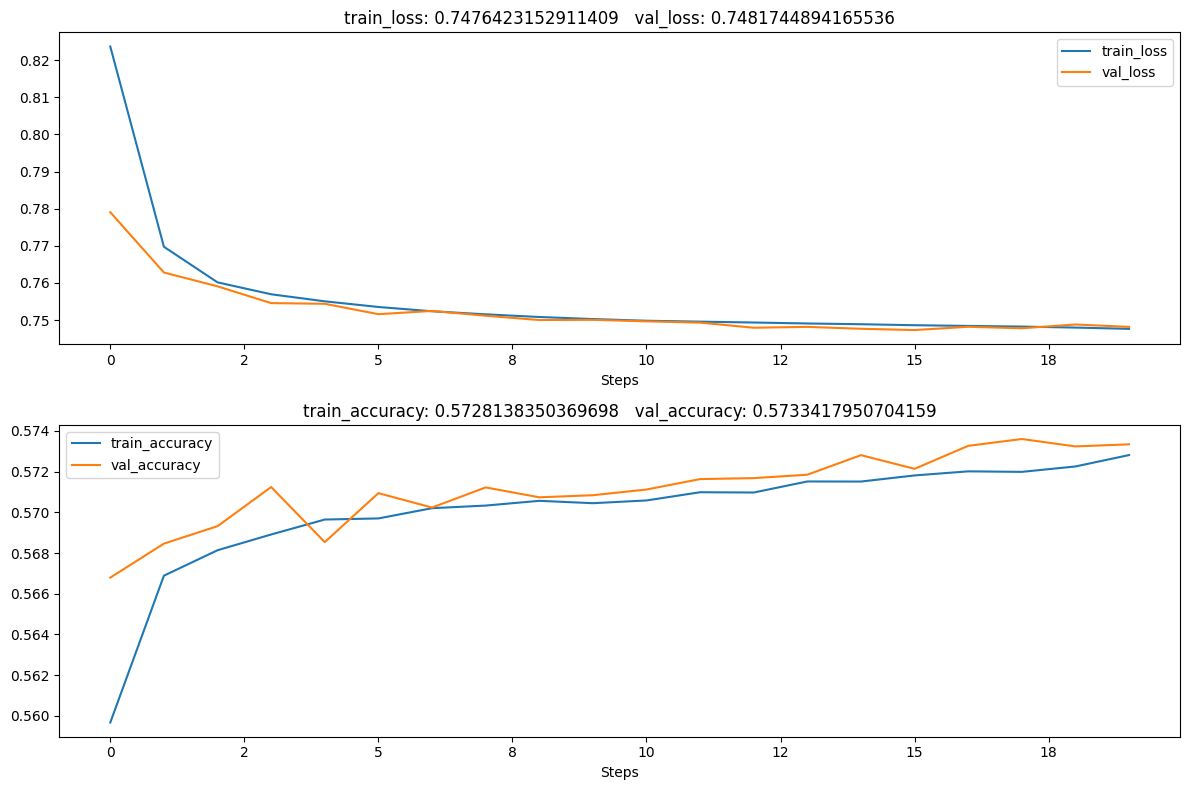

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_NN.parameters(), lr=0.001)

num_epochs = 20

loss_train, acc_train, loss_val, acc_val = train(
    base_NN, optimizer, criterion, train_loader, val_loader, num_epochs
)

In [ ]:
# Test the model
test_loss, test_accuracy = test(base_NN, test_loader, criterion)

Test Loss: 0.7507, Test Accuracy: 0.5721


### More complex NN with multiple hidden layers
We also implemented a more complex neural network model with multiple hidden layers to capture more patterns in the data. 

In [ ]:
# Instantiate the model
input_dim = X_nn_train.shape[1]  # Number of input features
hidden_dim = [32]  # Number of hidden units\
num_classes = y_nn_train.shape[1]  # Number of output classes


FNN = NeuralNetwork(input_dim, num_classes, hidden_dim)

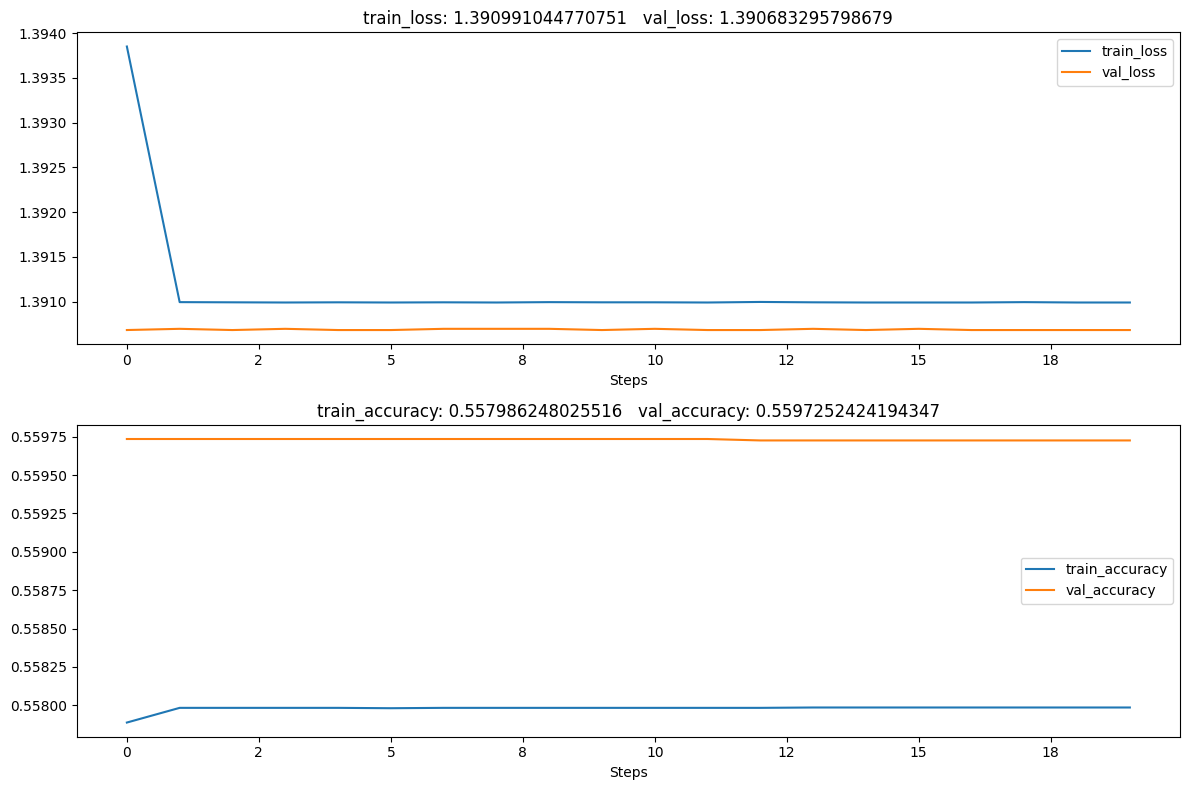

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FNN.parameters(), lr=0.001)

num_epochs = 20

loss_train, acc_train, loss_val, acc_val = train(
    FNN, optimizer, criterion, train_loader, val_loader, num_epochs
)

In [ ]:
# Test the model
test_loss, test_accuracy = test(FNN, test_loader, criterion)

Test Loss: 1.3917, Test Accuracy: 0.5575


### Results

## Conclusion

## References
- RING Software: https://ring.biocomputingup.it/
- PDB: https://www.rcsb.org/
- BioPython: https://biopython.org/